<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/Alexei-Grebnyov-folder/alexeigrebnyov/DatasetParsebyADmethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дополнительно к применяемой ранее логике обработки датасета:


1.   Удалены строки содержащие только NaN
2.   Удалены столбцы содержащие только нули
3.   В словаре использованном для замены строковых значений на числовые 0 присваивается только значениям '0'. Остальным значениям присваиваются 1 и более
4.  Из столбца 'ЗаключениеМК' удалены 'машинист бульдозера' и 'Газоспасатель'

В результате точность на DL-моделях вышла из неопределяемых значений и приблизилась к 0,9 на последних эпохах обучения.
В ML-моделях на первое место вышел GradientBoostingRegressor с	0.993590 точности и 1.09 % различий
Однако, рассмотрение отдельных случаев предсказания наталкивает на мысль, что эти значения относятся главным образом к предсказанию самым распостраненным классам заключения, и в первую очередь к 1 (Годен к работе в казанных условиях). В связи с этим в дальнейшем планирую сосредоточиться на балансировке датасета, а так же нормализации данных.


In [ ]:
# Библиотека работы с массивами
import numpy as np

# Библиотека для работы с таблицами
import pandas as pd

# Последовательная модель НС
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Слой задания активационной функции <----- !!!
from tensorflow.keras.layers import Activation

# Утилиты предобработки данных
from tensorflow.keras import utils
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Разделение на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split

# Рисование графиков
import matplotlib.pyplot as plt
import statistics
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy import stats

%matplotlib inline

In [ ]:
# Загрузка датасета
df_CAT=pd.read_excel('датасет профпатолог часть.xlsx', sheet_name='Лист2')
df_CAT

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b8a33910-8eec-11ec-80fe-0cc47aab8067,98f9d761-8d65-11ec-80fe-0cc47aab8067,1988-04-25,Мужской,Мужской,2022-02-16,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0bb0d181-938c-11ec-80fe-0cc47aab8067,009aac7d-7bcf-11eb-80e8-0cc47aab8067,1984-04-17,Мужской,Мужской,2022-02-22,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,137af572-70a5-11ed-8109-0cc47aab8067,41a7c665-7098-11ed-8109-0cc47aab8067,1972-11-12,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,a9f70e4c-707f-11ed-8109-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,26310d7e-70a5-11ed-8109-0cc47aab8067,41a7c663-7098-11ed-8109-0cc47aab8067,1986-07-09,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,a9f70e4c-707f-11ed-8109-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,b2602553-705c-11ed-8109-0cc47aab8067,0dc52156-f1a9-11e9-80d1-0cc47aab8067,1994-05-12,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,e689a382-17b2-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,d0358b83-7065-11ed-8109-0cc47aab8067,6261a674-07c8-11e8-80c6-0cc47aab8067,1972-04-17,Женский,Женский,2022-11-30,Периодический,Периодический,False,21f2a93d-68f9-11e6-82dc-d897ba0a5c60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
conda list scikit

# packages in environment at C:\Users\Grebnev_A\Anaconda3:
#
# Name                    Version                   Build  Channel
scikit-image              0.19.2           py39hf11a4ad_0  
scikit-learn              1.0.2            py39hf11a4ad_1  
scikit-learn-intelex      2021.6.0         py39haa95532_0  

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Удаляем столбцы и строки где все значения NAN
df_cutted=df_CAT.dropna(axis=1, how='all')
df_cutted=df_CAT.dropna(axis=0, how='all')
df_cutted=df_cutted.drop(columns=['ДокументПрохождениеМедосмотра', 'Клиент'])

In [ ]:
df_cutted


,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,Цех,Профессия,...,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
0,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,NaN,Ведущий специалист по организации обуения,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,NaN,Ведущий специалист,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,NaN,Главный менеджер,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-04-25,Мужской,Мужской,2022-02-16,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,Отдел техники и технологии строительства скважин,Главный специалист,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984-04-17,Мужской,Мужской,2022-02-22,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,Отдел технологий текущего и капитального ремон...,Старший специалист,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,1972-11-12,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,a9f70e4c-707f-11ed-8109-0cc47aab8067,NaN,Директор по строительству,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,1986-07-09,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,a9f70e4c-707f-11ed-8109-0cc47aab8067,NaN,Начальник производственно-технического отдела,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,1994-05-12,Мужской,Мужской,2022-11-30,Периодический,Периодический,False,e689a382-17b2-11e9-80ce-0cc47aab8067,NaN,Помощник кладовщика,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,1972-04-17,Женский,Женский,2022-11-30,Периодический,Периодический,False,21f2a93d-68f9-11e6-82dc-d897ba0a5c60,NaN,Повар,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_cutted=df_cutted.dropna(subset=['ЗаключениеМК', 'Заключение','КлиентДатаРождения', 'ДатаЗавершенияМедосмотра'])

In [ ]:
df_cutted['ПсихОсвидетельствование'].dtypes

dtype('bool')

In [ ]:
# В остальных столбцах заменяем NAN на 0 соответствующего типа
import datetime
for i in df_cutted.columns.values.tolist():
    if df_cutted[i].dtypes==object:
       df_cutted[i]= df_cutted[i].fillna('0')
    elif df_cutted[i].dtypes==int or  df_cutted[i].dtypes==float:
       df_cutted[i]= df_cutted[i].fillna(0)
    else:
        df_cutted[i]= df_cutted[i].fillna(datetime.datetime.min )

In [ ]:
# Проверяем тип данных в полученном датасете
d={}
for i in df_cutted.columns.values.tolist():
    l=df_cutted[i].unique() 
    l1=[]
    for j in range(l.size):
        l1.append(type(l[j]))
    d.update({i:l1 })
d

{'КлиентДатаРождения': [numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64,
  numpy.datetime64

In [ ]:
# Отбираем столбцы с большим количеством уникальных значений
for i in d.keys():
    if len(d.get(i))>10:
        print(i, len(d.get(i)), sep=' ')

КлиентДатаРождения 1425
ДатаЗавершенияМедосмотра 83
Контрагент 142
Цех 173
Профессия 557
Заключение 14
ВредныеФакторы 389
ЛабораторныеИсследования1_ДокументПрием 1239
ЛабораторныеИсследования1_ДатаПриема 1235
Рентгенология1_ДокументПрием 75
Рентгенология1_ДатаПриема 74
ПсихиатрияНаркология1_ДокументПрием 1162
ПсихиатрияНаркология1_ДатаПриема 1162
ПсихиатрияНаркология1_ХР_РекомендацияСтр 13
ПсихиатрияНаркология1_ДатаПриема_Значение 1161
ПсихиатрияНаркология1_ДатаПриема_ЗначениеПредставление 1163
ПсихиатрияНаркология1_Внимание_Значение 170
ПсихиатрияНаркология1_Внимание_ЗначениеПредставление 173
ПсихиатрияНаркология1_Эмоционально_Значение 12
ПсихиатрияНаркология1_Эмоционально_ЗначениеПредставление 12
ПсихиатрияНаркология1_Диагноз_Значение 14
ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление 13
Офтальмология1_ДокументПрием 969
Офтальмология1_ДатаПриема 966
Офтальмология1_МКБ101 19
Офтальмология1_ДиагнозПредставление1 21
Офтальмология1_Детализация1 133
Офтальмология1_ДатаПриема_Значение 

In [ ]:
# В основном это столбцы с кодами документов не представляющие интереса для обучения, а также дублирующие столбцы (представление). Отберем их
excp=[]
for i in d.keys():
    item=d.get(i)
    if ('ДокументПрием' in i) or ('ДатаПрием' in i)or ('Представление' in i):
        excp.append(i)
excp

['КлиентПолПредставление',
 'ТипМедосмотраПредставление',
 'ЗаключениеМКПредставление',
 'ДиспансернаяГруппаПредставление',
 'ЛабораторныеИсследования1_ДокументПрием',
 'ЛабораторныеИсследования1_ДатаПриема',
 'ЛабораторныеИсследования1_СалонПредставление',
 'ЛабораторныеИсследования1_СпециализацияПредставление',
 'ЛабораторныеИсследования1_ХР_Рекомендация1Представление',
 'ЛабораторныеИсследования1_ХР_Рекомендация2Представление',
 'ЛабораторныеИсследования1_ОАК_ЗначениеПредставление',
 'ЛабораторныеИсследования1_Биохимия_ЗначениеПредставление',
 'ЛабораторныеИсследования1_ОАМ_ЗначениеПредставление',
 'ЛабораторныеИсследования1_МазокИзЗеваИНоса_ЗначениеПредставление',
 'ЛабораторныеИсследования1_Кал_ЗначениеПредставление',
 'ЛабораторныеИсследования1_RW_ЗначениеПредставление',
 'ЛабораторныеИсследования1_КровьНаЭнтеробиоз_ЗначениеПредставление',
 'Рентгенология1_ДокументПрием',
 'Рентгенология1_ДатаПриема',
 'Рентгенология1_СалонПредставление',
 'Рентгенология1_СпециализацияПредставлен

In [ ]:
# И удалим
df_new=df_cutted.drop(columns=excp)
df_new

,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Контрагент,Цех,Профессия,ЗаключениеМК,Заключение,...,Оториноларингология3_ВидимыеСлизистые_Значение,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение
0,1976-10-24,Женский,2022-01-25,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,0,Ведущий специалист по организации обуения,Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0
1,1987-11-18,Мужской,2022-02-02,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,0,Ведущий специалист,Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0
2,1985-09-08,Мужской,2022-02-15,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,0,Главный менеджер,ГоденСКоррекциейЗрения,Годен к работе в указанных условиях (с коррекц...,...,0,0,0,0,0,0,0,0,0,0
3,1988-04-25,Мужской,2022-02-16,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,Отдел техники и технологии строительства скважин,Главный специалист,Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0
4,1984-04-17,Мужской,2022-02-22,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,Отдел технологий текущего и капитального ремон...,Старший специалист,ГоденСКоррекциейЗрения,Годен к работе в указанных условиях (с коррекц...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,1986-06-18,Мужской,2022-11-30,Периодический,False,a30f4a53-de4e-11eb-80f6-0cc47aab8067,Отдел диагностики,Инженер,Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0
1961,1993-12-29,Мужской,2022-11-30,Периодический,False,a30f4a53-de4e-11eb-80f6-0cc47aab8067,Отдел диагностики,Инженер,Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0
1962,1989-07-10,Мужской,2022-11-30,Периодический,False,a30f4a53-de4e-11eb-80f6-0cc47aab8067,Элетротехническая лаборатория,Начальник лаборатории,Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0
1972,1987-02-04,Мужской,2022-11-30,Периодический,False,d366a562-5a32-11ea-80db-0cc47aab8067,0,"Инженер по бурению 1 категории, непосредственн...",Годен,Годен к работе в указанных условиях,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Еще один столбец с кодами. Тоже удаляем
df_new=df_new.drop(columns=['Контрагент'])

In [ ]:

df_new.describe()

,ЛабораторныеИсследования1_ХР_РекомендацияСтр,Рентгенология1_ХР_Рекомендация1,Рентгенология1_ХР_Рекомендация2,Рентгенология1_ХР_РекомендацияСтр,Рентгенология2_ХР_Рекомендация1,Рентгенология2_ХР_Рекомендация2,Рентгенология2_ХР_РекомендацияСтр,ПсихиатрияНаркология1_Профессиональное1,ПсихиатрияНаркология1_Чистая_Значение,ПсихиатрияНаркология1_СоСледамиВВИнъекций_Значение,...,Психиатрия4_Классификация32,Психиатрия4_Противопоказание2,Оториноларингология3_ХР_Рекомендация1,Оториноларингология3_ХР_Рекомендация2,Оториноларингология3_ХР_РекомендацияСтр,Оториноларингология3_Детализация1,Оториноларингология3_Классификация11,Оториноларингология3_Классификация21,Оториноларингология3_Классификация31,Оториноларингология3_Противопоказание1
count,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.00000,1563.0,...,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0,1563.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03576,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

d0=[]
for i in df_new.columns.values.tolist():
    if df_new[i][df_new[i]==0].count()==1563:
        d0.append(i)
d0

['ЛабораторныеИсследования1_ХР_РекомендацияСтр',
 'Рентгенология1_ХР_Рекомендация1',
 'Рентгенология1_ХР_Рекомендация2',
 'Рентгенология1_ХР_РекомендацияСтр',
 'Рентгенология2_ХР_Рекомендация1',
 'Рентгенология2_ХР_Рекомендация2',
 'Рентгенология2_ХР_РекомендацияСтр',
 'ПсихиатрияНаркология1_Профессиональное1',
 'ПсихиатрияНаркология1_СоСледамиВВИнъекций_Значение',
 'ПсихиатрияНаркология1_НеКонтактен_Значение',
 'ПсихиатрияНаркология1_НеАдекватен_Значение',
 'Офтальмология1_Профессиональное1',
 'Оториноларингология1_ХР_РекомендацияСтр',
 'Оториноларингология1_Классификация21',
 'Оториноларингология1_Классификация31',
 'Оториноларингология1_Противопоказание1',
 'Оториноларингология1_Профессиональное1',
 'Оториноларингология1_УвеличеныСПробками_Значение',
 'Оториноларингология1_УвеличеныСЛакунарнымНалетом_Значение',
 'ХирургНеИсп1_ХР_Рекомендация1',
 'ХирургНеИсп1_ХР_Рекомендация2',
 'ХирургНеИсп1_ХР_РекомендацияСтр',
 'ХирургНеИсп1_Детализация1',
 'ХирургНеИсп1_Классификация11',
 'Хирур

In [ ]:
df_new=df_new.drop(columns=d0)
df_new

,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,...,Оториноларингология3_ВидимыеСлизистые_Значение,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение
0,1976-10-24,Женский,2022-01-25,Периодический,False,0,Ведущий специалист по организации обуения,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,0
1,1987-11-18,Мужской,2022-02-02,Периодический,False,0,Ведущий специалист,Годен,Годен к работе в указанных условиях,IIIа,...,0,0,0,0,0,0,0,0,0,0
2,1985-09-08,Мужской,2022-02-15,Периодический,False,0,Главный менеджер,ГоденСКоррекциейЗрения,Годен к работе в указанных условиях (с коррекц...,II,...,0,0,0,0,0,0,0,0,0,0
3,1988-04-25,Мужской,2022-02-16,Периодический,False,Отдел техники и технологии строительства скважин,Главный специалист,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,0
4,1984-04-17,Мужской,2022-02-22,Периодический,False,Отдел технологий текущего и капитального ремон...,Старший специалист,ГоденСКоррекциейЗрения,Годен к работе в указанных условиях (с коррекц...,II,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,1986-06-18,Мужской,2022-11-30,Периодический,False,Отдел диагностики,Инженер,Годен,Годен к работе в указанных условиях,II,...,0,0,0,0,0,0,0,0,0,0
1961,1993-12-29,Мужской,2022-11-30,Периодический,False,Отдел диагностики,Инженер,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,0
1962,1989-07-10,Мужской,2022-11-30,Периодический,False,Элетротехническая лаборатория,Начальник лаборатории,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,0
1972,1987-02-04,Мужской,2022-11-30,Периодический,False,0,"Инженер по бурению 1 категории, непосредственн...",Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_new=df_new.reset_index(drop=True)

In [ ]:
from dateutil.relativedelta import relativedelta

dates={}
vals=[]
for i in range(df_new['КлиентДатаРождения'].size):
    d1 = df_new['КлиентДатаРождения'][i]
    d2 = df_new['ДатаЗавершенияМедосмотра'][i]
    vals.append(relativedelta(d2, d1).years)
dates.update({'dateDiff':vals})
dates

{'dateDiff': [45,
  34,
  36,
  33,
  37,
  27,
  36,
  27,
  43,
  32,
  29,
  46,
  32,
  31,
  36,
  24,
  63,
  39,
  39,
  33,
  50,
  32,
  37,
  50,
  33,
  20,
  47,
  54,
  57,
  43,
  39,
  51,
  58,
  61,
  50,
  53,
  64,
  46,
  31,
  35,
  47,
  27,
  50,
  54,
  37,
  31,
  41,
  35,
  26,
  37,
  40,
  28,
  34,
  33,
  59,
  44,
  34,
  44,
  38,
  42,
  28,
  59,
  29,
  23,
  29,
  36,
  58,
  37,
  57,
  28,
  45,
  44,
  41,
  30,
  53,
  57,
  42,
  34,
  60,
  36,
  50,
  24,
  43,
  53,
  36,
  37,
  56,
  28,
  45,
  45,
  50,
  56,
  42,
  48,
  37,
  46,
  31,
  32,
  55,
  43,
  38,
  28,
  62,
  50,
  37,
  32,
  45,
  29,
  33,
  43,
  28,
  36,
  48,
  29,
  53,
  30,
  23,
  21,
  22,
  32,
  27,
  54,
  30,
  57,
  43,
  19,
  20,
  35,
  40,
  47,
  37,
  59,
  43,
  55,
  30,
  56,
  34,
  53,
  28,
  57,
  55,
  41,
  37,
  34,
  46,
  60,
  39,
  41,
  24,
  40,
  49,
  58,
  49,
  51,
  43,
  42,
  24,
  47,
  36,
  39,
  24,
  36,
  25,
  44,
  56

In [ ]:
df_app=pd.DataFrame.from_dict(dates)
df_new=pd.concat((df_new, df_app), axis=1)
df_new

,КлиентДатаРождения,КлиентПол,ДатаЗавершенияМедосмотра,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,...,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,dateDiff
0,1976-10-24,Женский,2022-01-25,Периодический,False,0,Ведущий специалист по организации обуения,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,45
1,1987-11-18,Мужской,2022-02-02,Периодический,False,0,Ведущий специалист,Годен,Годен к работе в указанных условиях,IIIа,...,0,0,0,0,0,0,0,0,0,34
2,1985-09-08,Мужской,2022-02-15,Периодический,False,0,Главный менеджер,ГоденСКоррекциейЗрения,Годен к работе в указанных условиях (с коррекц...,II,...,0,0,0,0,0,0,0,0,0,36
3,1988-04-25,Мужской,2022-02-16,Периодический,False,Отдел техники и технологии строительства скважин,Главный специалист,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,33
4,1984-04-17,Мужской,2022-02-22,Периодический,False,Отдел технологий текущего и капитального ремон...,Старший специалист,ГоденСКоррекциейЗрения,Годен к работе в указанных условиях (с коррекц...,II,...,0,0,0,0,0,0,0,0,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,1986-06-18,Мужской,2022-11-30,Периодический,False,Отдел диагностики,Инженер,Годен,Годен к работе в указанных условиях,II,...,0,0,0,0,0,0,0,0,0,36
1559,1993-12-29,Мужской,2022-11-30,Периодический,False,Отдел диагностики,Инженер,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,28
1560,1989-07-10,Мужской,2022-11-30,Периодический,False,Элетротехническая лаборатория,Начальник лаборатории,Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,33
1561,1987-02-04,Мужской,2022-11-30,Периодический,False,0,"Инженер по бурению 1 категории, непосредственн...",Годен,Годен к работе в указанных условиях,I,...,0,0,0,0,0,0,0,0,0,35


In [ ]:
df_new=df_new.drop(columns=['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра'])


In [ ]:
df_new=df_new.reset_index(drop=True)

In [ ]:
dicts={}
for i in df_new.columns.values.tolist():
    if df_new[i].dtypes==object:
        c=0
        dl={}
        for j in df_new[i].unique():
            if j=='0':
                dl.update({j:0})
            else:
                c+=1
                dl.update({j:c})
        dicts.update({i:dl})
dicts       
    

{'КлиентПол': {'Женский': 1, 'Мужской': 2},
 'ТипМедосмотра': {'Периодический': 1, 'Предварительный': 2},
 'Цех': {'0': 0,
  'Отдел техники и технологии строительства скважин': 1,
  'Отдел технологий текущего и капитального ремонта скважин': 2,
  'Без отдела': 3,
  'Отдел подготовительных работ и хранения керна': 4,
  'отдел разработки и внедрения ОРЭ': 5,
  'отдел повышения эффективности процесса подготовки': 6,
  'Отдел обследования зданий и сооружений': 7,
  'лаборатория физико-химических ислледований': 8,
  'отдел административно-хозяйственного обеспечения': 9,
  'отдел геодезический изысканий': 10,
  'отдел выпуска и хранения документации': 11,
  'отдел авторского надзора': 12,
  'зал': 13,
  'Км матур': 14,
  'Отдел электротехнологий': 15,
  'кухня': 16,
  'Отдел технических решений и проектов': 17,
  'Отдел технологии литья': 18,
  'ОТдел мониторинга и авторского сопровождения строительства скважин': 19,
  'Администрация': 20,
  'Учебный отдел': 21,
  'РТР': 22,
  'Административ

In [ ]:
df_new=df_new.loc[~df_new['ЗаключениеМК'].isin(["машинист бульдозера", 'Газоспасатель', ' Газоспасатель'])]

In [ ]:
df_new=df_new.reset_index(drop=True)

In [ ]:
df_fl=df_new.copy()
for i in dicts.keys():
    for j in range(df_new[i].shape[0]):
        df_fl[i][j]=float(dicts.get(i).get(df_new[i][j]))
df_fl

,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,ВредныеФакторы,ЛабораторныеИсследования1_Салон,...,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,dateDiff
0,1.0,1.0,False,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45
1,2.0,1.0,False,0.0,2.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34
2,2.0,1.0,False,0.0,3.0,2.0,2.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
3,2.0,1.0,False,1.0,4.0,1.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
4,2.0,1.0,False,2.0,5.0,2.0,2.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,2.0,1.0,False,42.0,206.0,1.0,1.0,3.0,160.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
1555,2.0,1.0,False,42.0,206.0,1.0,1.0,1.0,160.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28
1556,2.0,1.0,False,67.0,555.0,1.0,1.0,1.0,18.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
1557,2.0,1.0,False,0.0,556.0,1.0,1.0,1.0,388.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35


In [ ]:
df_fl=df_fl.astype(float)
df_fl

,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,ВредныеФакторы,ЛабораторныеИсследования1_Салон,...,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,dateDiff
0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
1,2.0,1.0,0.0,0.0,2.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
2,2.0,1.0,0.0,0.0,3.0,2.0,2.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
3,2.0,1.0,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
4,2.0,1.0,0.0,2.0,5.0,2.0,2.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,2.0,1.0,0.0,42.0,206.0,1.0,1.0,3.0,160.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
1555,2.0,1.0,0.0,42.0,206.0,1.0,1.0,1.0,160.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1556,2.0,1.0,0.0,67.0,555.0,1.0,1.0,1.0,18.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
1557,2.0,1.0,0.0,0.0,556.0,1.0,1.0,1.0,388.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0


In [ ]:
df_fl.to_excel('df_flxl_new.xlsx')

In [ ]:
df_fl=pd.read_excel('df_flxl_new.xlsx')
df_fl

,Unnamed: 0,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,ВредныеФакторы,...,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,dateDiff
0,0,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,45
1,1,2,1,0,0,2,1,1,2,2,...,0,0,0,0,0,0,0,0,0,34
2,2,2,1,0,0,3,2,2,3,2,...,0,0,0,0,0,0,0,0,0,36
3,3,2,1,0,1,4,1,1,1,3,...,0,0,0,0,0,0,0,0,0,33
4,4,2,1,0,2,5,2,2,3,3,...,0,0,0,0,0,0,0,0,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,1554,2,1,0,42,206,1,1,3,160,...,0,0,0,0,0,0,0,0,0,36
1555,1555,2,1,0,42,206,1,1,1,160,...,0,0,0,0,0,0,0,0,0,28
1556,1556,2,1,0,67,555,1,1,1,18,...,0,0,0,0,0,0,0,0,0,33
1557,1557,2,1,0,0,556,1,1,1,388,...,0,0,0,0,0,0,0,0,0,35


In [ ]:
df_fl=df_fl.drop([1]).reset_index(drop=True)

In [ ]:
df_fl.describe()

,Unnamed: 0,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,ВредныеФакторы,...,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,dateDiff
count,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,...,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000
mean,990.999495,1.731954,1.000505,0.035336,29.215043,252.064614,2.338213,2.827865,2.468955,164.996971,...,1.000505,1.000505,1.000505,1.000505,1.000505,1.000505,1.000505,1.000505,1.000505,40.647148
std,572.010636,0.443054,0.022468,0.184673,45.986946,187.263173,2.431007,3.302456,1.538946,137.532288,...,0.022468,0.022468,0.022468,0.022468,0.022468,0.022468,0.022468,0.022468,0.022468,11.561482
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000
25%,496.000000,1.000000,1.000000,0.000000,1.000000,83.000000,1.000000,1.000000,1.000000,36.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000
50%,991.000000,2.000000,1.000000,0.000000,1.000000,213.000000,1.000000,1.000000,2.000000,141.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.000000
75%,1486.000000,2.000000,1.000000,0.000000,47.000000,403.000000,2.000000,2.000000,3.000000,252.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.000000
max,1981.000000,2.000000,2.000000,1.000000,184.000000,690.000000,10.000000,15.000000,8.000000,515.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,71.000000


In [ ]:
df_fl=df_fl.drop(df_fl[df_fl['dateDiff']==0].index).reset_index(drop=True)
df_fl

,Unnamed: 0,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,Цех,Профессия,ЗаключениеМК,Заключение,ДиспансернаяГруппа,ВредныеФакторы,...,Оториноларингология3_СВысыпаниями_Значение,Оториноларингология3_НебныеМиндалины1_Значение,Оториноларингология3_НебныеМиндалины2_Значение,Оториноларингология3_ВестибулярныйАнализатор1_Значение,Оториноларингология3_Аудиометрия1_Значение,Оториноларингология1_ЖалобыДополнение_Значение,Стоматология2_ВП2_Значение,Терапия2_ЗаключениеФОГК_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,dateDiff
0,0,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,45
1,2,2,1,0,0,3,2,2,3,2,...,0,0,0,0,0,0,0,0,0,36
2,3,2,1,0,1,4,1,1,1,3,...,0,0,0,0,0,0,0,0,0,33
3,4,2,1,0,2,5,2,2,3,3,...,0,0,0,0,0,0,0,0,0,37
4,5,2,1,0,0,5,1,1,3,3,...,0,0,0,0,0,0,0,0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1554,2,1,0,42,206,1,1,3,160,...,0,0,0,0,0,0,0,0,0,36
1554,1555,2,1,0,42,206,1,1,1,160,...,0,0,0,0,0,0,0,0,0,28
1555,1556,2,1,0,67,555,1,1,1,18,...,0,0,0,0,0,0,0,0,0,33
1556,1557,2,1,0,0,556,1,1,1,388,...,0,0,0,0,0,0,0,0,0,35


In [ ]:
x=df_fl.drop(columns=['Заключение']).reset_index(drop=True)
y=df_fl['Заключение']
x, y

(      Unnamed: 0  КлиентПол  ТипМедосмотра  ПсихОсвидетельствование  Цех  \
 0              0          1              1                        0    0   
 1              2          2              1                        0    0   
 2              3          2              1                        0    1   
 3              4          2              1                        0    2   
 4              5          2              1                        0    0   
 ...          ...        ...            ...                      ...  ...   
 1553        1554          2              1                        0   42   
 1554        1555          2              1                        0   42   
 1555        1556          2              1                        0   67   
 1556        1557          2              1                        0    0   
 1557        1558          2              1                        1    0   
 
       Профессия  ЗаключениеМК  ДиспансернаяГруппа  ВредныеФакторы  \
 0  

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

In [ ]:
# Получение списка значений разницы между y_test и pred
def test_pred_diff_plot(test, pred, method):
    l_dl=[]
    print(method)
    for i in range(0, len(test)):
        print(test[i],pred[i], sep=' ')
        dif=(abs(test[i]-pred[i])/test[i])*100
        if dif != float("inf"):
            l_dl.append(dif)
    return l_dl

In [ ]:
def ml_method_estim(method_list,  x_train, x_test, y_train, y_test):

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

    y_train=np.reshape(y_train.values, (-1,1))
    y_test=np.reshape(y_test.values, (-1,1))

    methods=[]
    MAE_list=[]
    R_2_list=[]
    MSE_list=[]
    diff_list=[]
    valscore_list=[]
    plots=[]
    for i in method_list:
        model=i.fit(x_train, y_train)
        p1=model.predict(x_test)

        mae=mean_absolute_error(y_test, p1)
        r2=r2_score(y_test, p1)
        mse=mean_squared_error(y_test, p1)
        acc_list=[]
        diff_list=[]
        valscore_list=[]
        plots=[]
    for i in method_list:
      
        model=i.fit(x_train, y_train)
        p1=model.predict(x_test)

        mae=mean_absolute_error(y_test, p1)
        r2=r2_score(y_test, p1)
        mse=mean_squared_error(y_test, p1)
        if i !=LinearRegression():
            acc=accuracy_score(y_test, p1.round())
        else:
            acc='--'


        fold = KFold(n_splits=6, shuffle=True, random_state=5)
        # scores = cross_val_score(estimator = model,X=x_train_scaled, y=y_train_scaled,cv=fold)
        scores = cross_val_score(estimator = model,X=x_train, y=y_train,cv=fold)


        methods.append(str(i))
        MAE_list.append(mae)
        R_2_list.append(r2)
        MSE_list.append(mse)
        acc_list.append(acc)
        valscore_list.append(scores.mean())

        diff=test_pred_diff_plot(y_test, p1, i)
        plots.append(diff)
        diff_list.append(sum(diff)/len(y_test))

    method_col=pd.Series(methods)
    mae_col=pd.Series(MAE_list)
    r_2_col=pd.Series(R_2_list)
    mse_col=pd.Series(MSE_list)
    acc_col=pd.Series(acc_list)
    valscore_col=pd.Series(valscore_list)
    estim_df=pd.DataFrame({'method':method_col, 'mae':mae_col, 'r_2':r_2_col, 'mse':mse_col, 'acc':acc_col, 'mean_diff(%)':diff_list, 'mean_val_score':valscore_col})

    count=0
    for k in plots:
        plt.plot(k, label=str(count))
        count+=1
    plt.legend()
    plt.title('Величина различий реальных и предсказанных значений в % в зависимости от методики')
    plt.show()


    return estim_df


[20:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
LinearRegression()
[1] [-116318.79790664]
[1] [1.21254088]
[1] [1.0978557]
[1] [1.18998737]
[1] [1.25386993]
[1] [0.86256083]
[1] [1.02486812]
[1] [0.94631993]
[1] [1.30252479]
[1] [1.04240366]
[1] [4173151.71018598]
[1] [1.10618801]
[1] [0.28243707]
[1] [-9049861.0584841]
[1] [0.85963801]
[1] [0.68124444]
[1] [1.09168609]
[1] [1.50813103]
[2] [2.237474]
[1] [0.93533536]
[1] [0.95774608]
[1] [0.98893501]
[1] [0.84428249]
[1] [0.79191548]
[1] [0.76823654]
[1] [1.1202342]
[1] [0.98009498]
[1] [1.49799904]
[1] [-4801654.38378299]
[1] [1.01242677]
[1] [0.97252869]
[2] [1.77232021]
[1] [1.28615736]
[1] [-1548526.04927428]
[1] [0.6755572]
[1] [0.8290063]
[1] [0.81494768]
[1] [1.06886743]
[1] [0.92523038]
[1] [0.98288973]
[1] [0.79958448]
[1] [1.01041273]
[2] [2.190

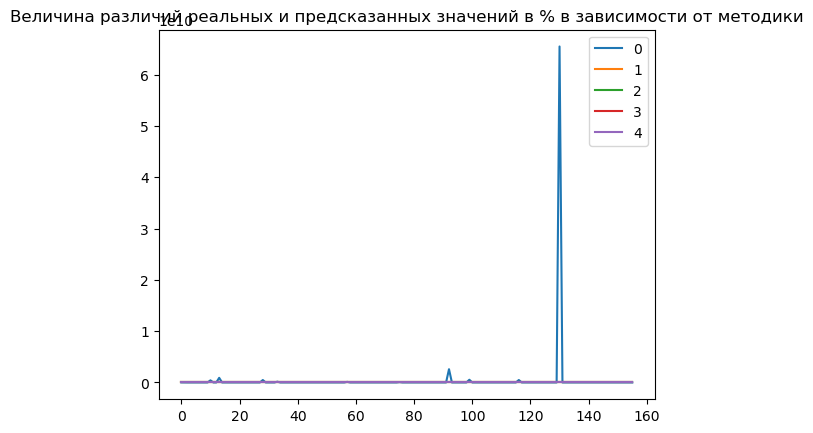

,method,mae,r_2,mse,acc,mean_diff(%),mean_val_score
0,LinearRegression(),4.568531e+06,-6.065633e+15,2.756653e+15,0.826923,[456853065.0772815],-1.044410e+18
1,"KNeighborsRegressor(metric='euclidean', n_neig...",2.403846e-01,-1.397529e-01,5.179843e-01,0.852564,[15.204008954008955],-4.052594e-01
2,"RandomForestRegressor(max_depth=3, random_stat...",4.833693e-02,8.484667e-01,6.886746e-02,0.980769,[2.2649304143723823],-2.417879e-01
3,GradientBoostingRegressor(random_state=0),3.131239e-02,8.016515e-01,9.014361e-02,0.993590,[1.091064661169789],-8.802039e-01
4,"XGBRegressor(base_score=None, booster=None, ca...",3.077614e-02,9.709838e-01,1.318702e-02,0.987179,[1.765788902365972],-1.150227e+00


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

l=[LinearRegression(), KNeighborsRegressor(n_neighbors=6, metric='euclidean'), RandomForestRegressor(max_depth=3, random_state=0), GradientBoostingRegressor(random_state=0),xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)]
ml_method_estim(l, x_train, x_test, y_train, y_test)

In [ ]:
def dl_method_estim(dl_method_list, x_dl_train, x_dl_test, y_dl_train,  y_dl_test):

#     x_dl_train, x_dl_test, y_dl_train,  y_dl_test = train_test_split(x, y, test_size=0.1, shuffle=True)


    y_dl_test =np.reshape(y_dl_test.values,(-1,1))
    y_dl_train =np.reshape(y_dl_train.values,(-1,1))
    plots=[]
    cols={}

    
    for i in dl_method_list:
        
        history=i.fit(x_dl_train, y_dl_train,   epochs=120, batch_size=4,   validation_split=0.1,   verbose=1)
        plt.plot(history.history['accuracy'],
                 label='Точность на обучающем наборе')           # Отрисовка графика обучения
        plt.plot(history.history['val_accuracy'],
                 label='Точность на проверочном наборе')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Точность')
        plt.legend()
        plt.show()

        pred=i.predict(x_dl_test)

        # График отношения реальных (test) и предсказанных(pred) значений. При текущем объеме выборки наверно малоинформативен.
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(y_dl_test, pred)
        ax.plot(plt.xlim(), plt.ylim(), 'r')
        plt.xlabel('test')
        plt.ylabel('pred')
        plt.grid()
        plt.title('Соотношение реальных и предсказанных значений')
        plt.show()

        plots.append(test_pred_diff_plot(y_dl_test, pred, i))
    count=0
    # Сравнение различий реальных и предсказанных между разными архитектурами сетей
    for k in plots:
        plt.plot(k, label=str(count))
        cols[str(count)]=k
        count+=1
    plt.legend()
    plt.title('Величина различий реальных и предсказанных значений в % в зависимости от архитектуры сети')
    plt.show()
    print('Среднее значение %-та различий реальных и предсказанных значений: model_1: {:.3f}, model_2: {:.3f}'.format(float(sum(cols['0'])/len(cols['0'])), float(sum(cols['1'])/len(cols['1']))))
    # dl_table=pd.DataFrame(cols)
    return pd.DataFrame(cols)

In [ ]:
def get_dl_list(input_dim):
    dl_method_list=[]
    dl_model_1=Sequential()
    dl_model_1.add(Dense(64, input_dim=input_dim, activation='relu'))
    dl_model_1.add(Dense(32, activation='relu'))
    dl_model_1.add(Dense(1, activation='linear'))
    dl_model_1.compile(loss='mse',
                  optimizer=Adam(learning_rate=1e-5), metrics=['accuracy', 'mape'])
    dl_model_1.summary()
    model_2 = Sequential()
    model_2.add(Dense(128,activation='relu', input_dim=input_dim))
    model_2.add(Dense(64, activation='relu'))
    model_2.add(Dense(32, activation='relu'))
    model_2.add(Dense(1, activation='linear'))

    model_2.compile(optimizer= Adam(learning_rate=1e-5), loss='mse', metrics=['accuracy', 'mape'])
    dl_method_list.append(dl_model_1)
    dl_method_list.append(model_2)
    return dl_method_list

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                108736    
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 110,849
Trainable params: 110,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
316/316 [==============================] - 2s 3ms/step - loss: 694.7701 - accuracy: 0.8660 - mape: 2025.8705 - val_loss: 163.2177 - val_accuracy: 0.7376 - val_mape: 957.1557
Epoch 2/120
316/316 [==============================] - 1s 3ms/step - loss: 97.4404 - accuracy: 0.6257 - mape: 719.0486 - val_l

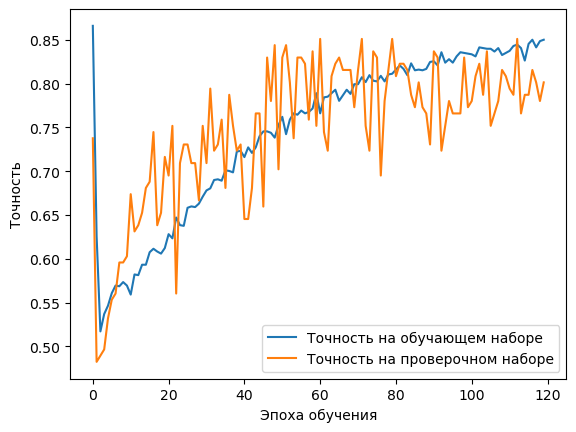

5/5 [==============================] - 0s 2ms/step


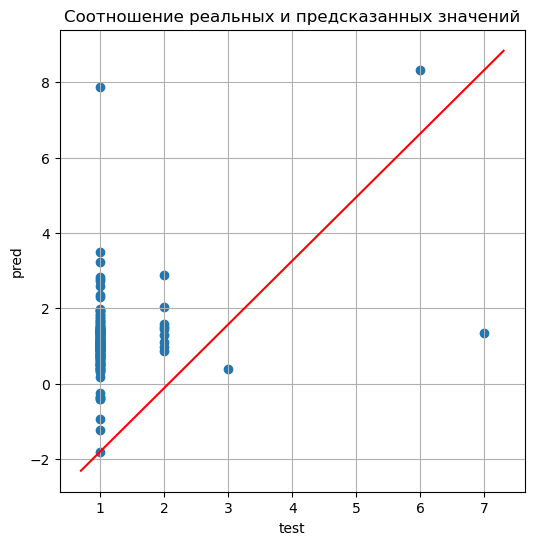

[1] [1.2499892]
[1] [1.656166]
[1] [1.0662268]
[1] [0.38575834]
[1] [0.50327295]
[1] [1.3749217]
[1] [1.4240187]
[1] [1.5609702]
[1] [1.0121791]
[1] [0.37411684]
[1] [0.9984903]
[1] [1.0935584]
[1] [1.1609629]
[1] [0.5448455]
[1] [0.3358268]
[1] [0.90043825]
[1] [1.5378321]
[1] [1.2820548]
[2] [1.5741032]
[1] [1.5197543]
[1] [3.237482]
[1] [0.9106197]
[1] [2.579092]
[1] [0.5271296]
[1] [1.5090102]
[1] [0.9527225]
[1] [0.1698455]
[1] [2.8183308]
[1] [-0.35124213]
[1] [1.9565891]
[1] [0.41312402]
[2] [1.2799586]
[1] [1.392599]
[1] [1.7805697]
[1] [1.113243]
[1] [0.9721088]
[1] [1.4094943]
[1] [0.70423883]
[1] [1.2016524]
[1] [0.6622161]
[1] [2.3498878]
[1] [1.0574311]
[2] [1.4452761]
[1] [1.1479625]
[1] [0.81650823]
[1] [1.4399039]
[1] [1.4133319]
[1] [1.8480319]
[1] [0.8554382]
[1] [1.2862824]
[1] [2.7723465]
[1] [0.62290806]
[1] [1.3093308]
[1] [0.80206484]
[1] [0.9125623]
[1] [1.6734866]
[1] [1.42708]
[1] [-1.2406713]
[1] [0.6526508]
[1] [0.885189]
[7] [1.3544415]
[1] [1.919237]
[1] [

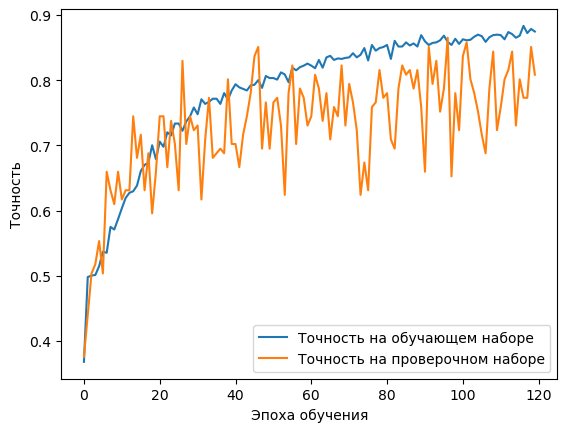

5/5 [==============================] - 0s 3ms/step


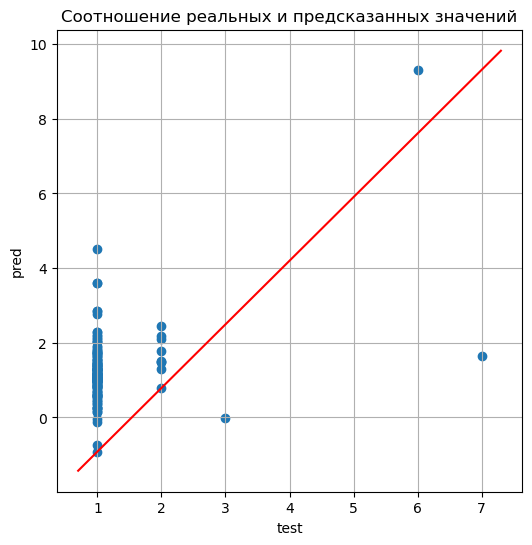

[1] [1.1134851]
[1] [0.2006781]
[1] [0.7856076]
[1] [0.25115228]
[1] [1.3887823]
[1] [0.86083627]
[1] [0.9768832]
[1] [0.1370356]
[1] [1.5689154]
[1] [0.5951655]
[1] [1.9018846]
[1] [0.98231053]
[1] [1.8821881]
[1] [0.9799731]
[1] [0.9170401]
[1] [1.6386621]
[1] [1.4052298]
[1] [1.1874182]
[2] [1.4789326]
[1] [1.1577976]
[1] [1.7028239]
[1] [0.8543856]
[1] [0.53515077]
[1] [1.2934301]
[1] [1.0582068]
[1] [1.0135825]
[1] [0.47484994]
[1] [0.968714]
[1] [3.5997736]
[1] [1.2593191]
[1] [1.2359393]
[2] [1.4854214]
[1] [0.5761342]
[1] [1.2939122]
[1] [0.43137765]
[1] [0.98868775]
[1] [1.2734139]
[1] [0.87845826]
[1] [2.1715186]
[1] [2.1353705]
[1] [1.8456194]
[1] [0.9538529]
[2] [1.5188487]
[1] [1.2783387]
[1] [0.59620357]
[1] [1.0388483]
[1] [0.94275975]
[1] [1.7066519]
[1] [1.7782366]
[1] [1.0592325]
[1] [4.512089]
[1] [0.7032118]
[1] [1.29795]
[1] [1.4474165]
[1] [0.56525254]
[1] [1.379844]
[1] [1.0892098]
[1] [2.0473673]
[1] [2.2210724]
[1] [0.24718307]
[7] [1.6422713]
[1] [1.5359728]
[

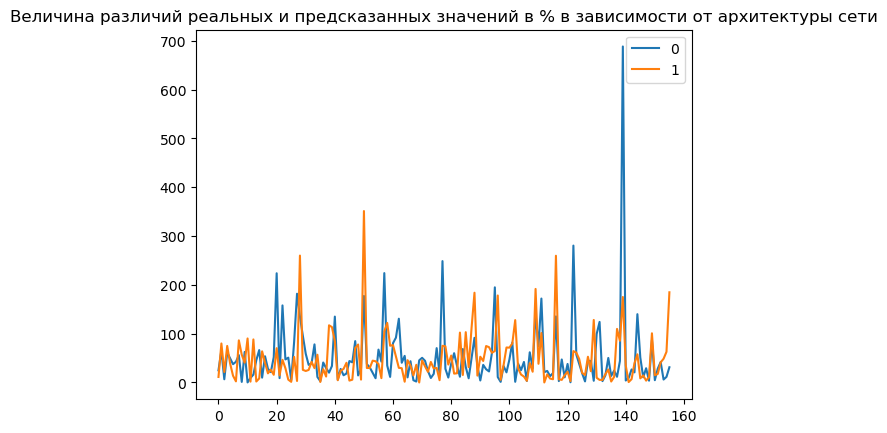

Среднее значение %-та различий реальных и предсказанных значений: model_1: 51.823, model_2: 48.377


,0,1
0,[24.998915195465088],[11.348509788513184]
1,[65.61659574508667],[79.93219047784805]
2,[6.622684001922607],[21.439242362976074]
3,[61.42416596412659],[74.88477230072021]
4,[49.67270493507385],[38.8782262802124]
...,...,...
151,[28.37923765182495],[17.5307035446167]
152,[41.89444184303284],[41.29679203033447]
153,[6.068998575210571],[48.63097667694092]
154,[11.523634195327759],[62.87877559661865]


In [ ]:
dl_method_estim(get_dl_list(1698),x_train, x_test, y_train, y_test)

In [ ]:
df_fl['Заключение'].values

array([1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 3., 2., 2., 2., 2.,
       2., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 6., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 7., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 3., 3., 2., 2., 2., 2., 2., 2., 6., 2., 2.,
       2., 2., 2., 8., 2., 5., 5., 2., 2., 3., 2., 2., 2., 3., 2., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5.])